# This is an implementation of a Convolutional Neural Network which will learn how to steer a car

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator, flip_axis, random_shift

from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, Lambda, Cropping2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from sklearn.model_selection import train_test_split
from scipy.misc import imread, imresize, toimage

# Visualizations will be shown inline
%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv("data/driving_log.csv", usecols=[0,1,2,3, 6])
df.describe(include="all")

,center,left,right,steering,speed
count,8036,8036,8036,8036.000000,8036.000000
unique,8036,8036,8036,NaN,NaN
top,IMG/center_2016_12_01_13_37_02_313.jpg,IMG/left_2016_12_01_13_37_15_965.jpg,IMG/right_2016_12_01_13_36_26_805.jpg,NaN,NaN
freq,1,1,1,NaN,NaN
mean,NaN,NaN,NaN,0.004070,28.169839
std,NaN,NaN,NaN,0.128840,6.149327
min,NaN,NaN,NaN,-0.942695,0.502490
25%,NaN,NaN,NaN,0.000000,30.183093
50%,NaN,NaN,NaN,0.000000,30.186400
75%,NaN,NaN,NaN,0.000000,30.186640


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a3a00e9b0>]], dtype=object)

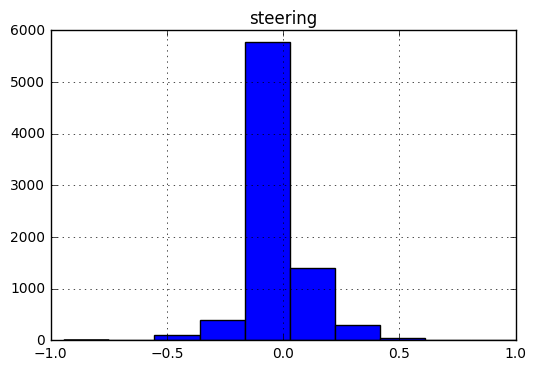

In [3]:
df.hist(column="steering")

## Print a random image from each camera

Shape:  (8036, 5)
Length:  8036
Random row:  446
Image shape <PIL.Image.Image image mode=RGB size=320x160 at 0x7F3A999DFFD0>


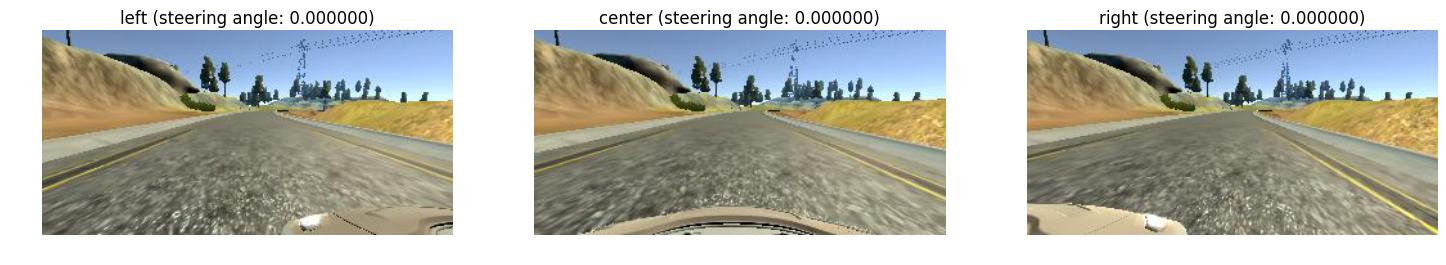

In [4]:
plt.rcParams["figure.figsize"] = (18, 10)

print("Shape: ", df.shape)
print("Length: ", len(df.index))

row = np.random.randint(len(df.index))
print("Random row: ", row)
print("Image shape {}".format(load_img("data/"+df.iloc[1]["center"].strip())))

i = 0
for camera in ["left", "center", "right"]:
    image = load_img("data/"+df.iloc[row][camera].strip())  #some columns have whitespace so strip it out
    image = img_to_array(image).astype("uint8")
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.axis('off')
    title = "{} (steering angle: {:.6f})".format(camera, df.iloc[row]["steering"])
    plt.title(title)
    i += 1

## Pre-processing the data
A can be seen when you look at some of the data above, most of the samples are with the car driving straight - i.e. close to zero steering angle.

Lets start by building a new data file but ignoring all the low speed entrie which are mainly driving straight:

In [5]:
def read_log_file(high_speed_only=False, turns_only=False):
    """
    Read and process the log file that has already been opened above (in this notebook).
    Return X, y dataset.
    """
    
    if high_speed_only:
        new_df = df[df.speed >= 20]
    else:
        new_df = df
        
    print("read_log_file df shape {}. New shape {}".format(df.shape, new_df.shape))
    
    steering_offset = 0.4
    X, y = [], []
    
    for center_img, left_img, right_img, steering_angle, speed in new_df.values:
        if turns_only:
            X += [left_img.strip(), right_img.strip()]
            y += [float(steering_angle) + steering_offset, float(steering_angle) - steering_offset]
        else:
            X += [center_img.strip(), left_img.strip(), right_img.strip()]
            y += [float(steering_angle), float(steering_angle) + steering_offset, float(steering_angle) - steering_offset]
    
    return X, y

In [6]:
def random_darken(image):
    """Given an image (from Image.open -> not a numpy array), randomly darken a part of it."""
    w, h = image.size

    # Make a random box.
    x1, y1 = random.randint(0, w), random.randint(0, h)
    x2, y2 = random.randint(x1, w), random.randint(y1, h)

    # Loop through every pixel of our box (*GASP*) and darken.
    for i in range(x1, x2):
        for j in range(y1, y2):
            new_value = tuple([int(x * 0.5) for x in image.getpixel((i, j))])
            image.putpixel((i, j), new_value)
    return image

In [7]:
def crop_and_resize(image, crop=(55, 135), shape=(100, 100, 3)):
    """
    Crop and Resize images to given shape.
    """
    height, width, channels = shape
    image_resized = np.empty([height, width, channels])
    
    crop_top = crop[0]
    crop_bottom = crop[1]
    cropped_image = image[crop_top:crop_bottom, :, :]
    image_resized = imresize(cropped_image, shape)

    return image_resized

#### Test cropping on some random images

Shape:  (8036, 5)
Length:  8036
Random row:  4898
Image shape <PIL.Image.Image image mode=RGB size=320x160 at 0x7F3A3607B2B0>


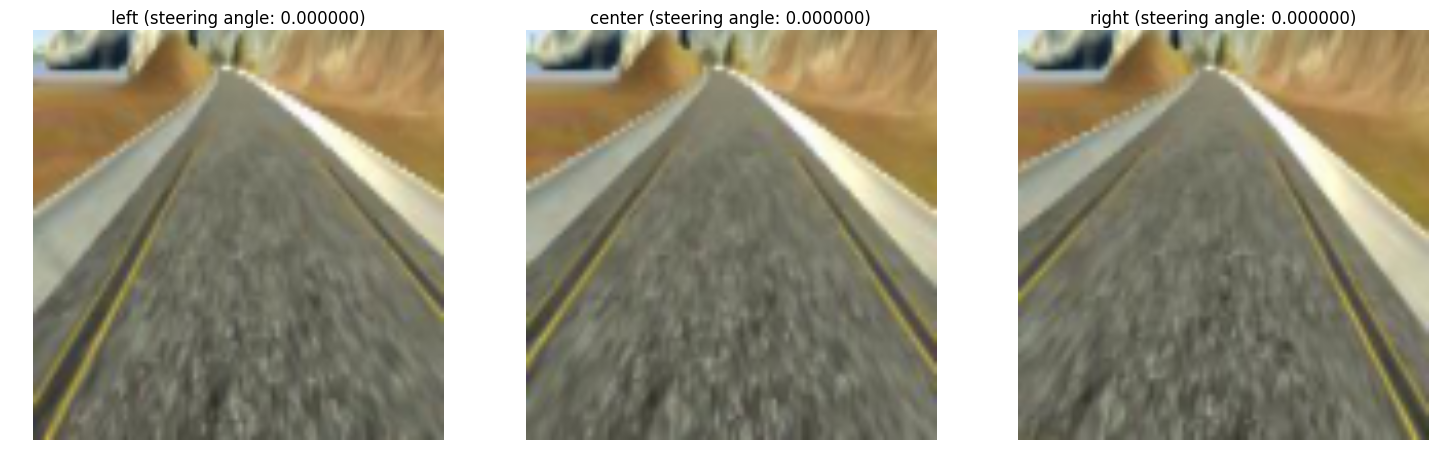

In [8]:
plt.rcParams["figure.figsize"] = (18, 10)

print("Shape: ", df.shape)
print("Length: ", len(df.index))

row = np.random.randint(len(df.index))
print("Random row: ", row)
print("Image shape {}".format(load_img("data/"+df.iloc[1]["center"].strip())))

i = 0
for camera in ["left", "center", "right"]:
    image = load_img("data/"+df.iloc[row][camera].strip())  #some columns have whitespace so strip it out
    image = img_to_array(image)
    image = crop_and_resize(image)
    plt.subplot(1, 3, i+1)
    plt.imshow(image.astype("uint8"))
    plt.axis('off')
    title = "{} (steering angle: {:.6f})".format(camera, df.iloc[row]["steering"])
    plt.title(title)
    i += 1

In [9]:
def process_image(image_path, steering_angle, augment):
    image = load_img(image_path)
    
    if augment and random.random() < 0.5:
        image = random_darken(image)  # before numpy'd
        
    image = img_to_array(image)
    
    if augment:
        image = random_shift(image, 0, 0.2, 0, 1, 2)  # only vertical
        if random.random() < 0.5:
            image = flip_axis(image, 1)
            steering_angle = -steering_angle
    
    return image.astype(np.float32), steering_angle

In [10]:
def preprocess(image):
    image = crop_and_resize(image)
    image = (image / 255. - .5).astype(np.float32) #normalize
    return image

In [11]:
def generator(X, y, batch_size):
    while 1:
        batch_X, batch_y = [], []
        
        for i in range(batch_size):
            sample_index = random.randint(0, len(X) - 1)
            steering_angle = y[sample_index]
            
            image, steering_angle = process_image("data/" + X[sample_index], steering_angle, augment=True)
            
            image = preprocess(image)
            
            batch_X.append(image)
            batch_y.append(steering_angle)
            
        yield np.array(batch_X), np.array(batch_y)

#### Lets run the generator function and print some images from the pipeline so we can see the augmentation

read_log_file df shape (8036, 5). New shape (8036, 5)


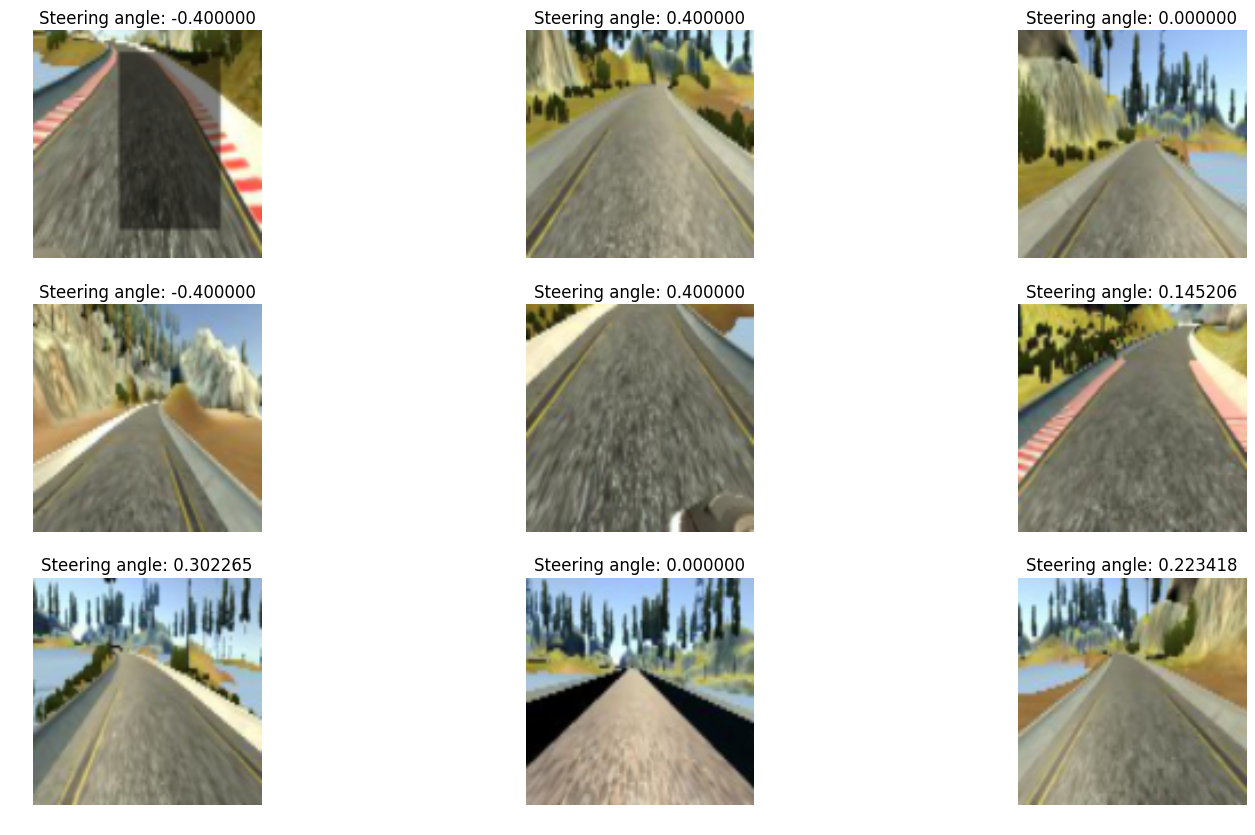

In [12]:
X, y = read_log_file(high_speed_only=False, turns_only=False)

plt.figure()
plt.rcParams["figure.figsize"] = (18, 10)

for pic in range(9):
    obj = generator(X, y, batch_size=1)
    next_batch = next(obj)
    
    image_from_array = next_batch[0][0]
    image_from_array = (image_from_array + .5) * 255 #undo the normalisation

    plt.subplot(3, 3, pic+1)
    plt.imshow(image_from_array.astype("uint8"))
    plt.axis('off')
    title = "Steering angle: {:.6f}".format(next_batch[1][0])
    plt.title(title)

## Build the ConvNet model

In [13]:
def model(load_model, shape):
    model = Sequential([
        Conv2D(32, 3, 3, input_shape=shape, activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(32, 3, 3, activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(32, 3, 3, activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, 3, 3, activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(128, 3, 3, activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(1024, activation="relu"),
        Dropout(0.5),
        
        Dense(512, activation="relu"),
        Dropout(0.5),
        
        Dense(1, activation="linear")
    ])

    model.compile(optimizer="adam", loss="mse")
    model.summary()
    
    return model

## Train the model

In [ ]:
nb_epochs = 10
batch_size = 64


early_stopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)
save_weights = ModelCheckpoint("save/model.h5", monitor="val_loss", save_best_only=True, save_weights_only=True)

#train_gen = ImageDataGenerator(
#    rescale=1./255)

net = model(load_model=False, shape=(100, 100, 3))

X, y = read_log_file(high_speed_only=True, turns_only=False)
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.10)

print("len X_train:", len(X_train))
print("len y_train:", len(y_train))
print("len X_val:", len(X_val))
print("len y_val:", len(y_val))

net.fit_generator(
    generator(X_train, y_train, batch_size=batch_size),
    samples_per_epoch=30016,
    nb_epoch=nb_epochs,
    callbacks=[early_stopping, save_weights],
    validation_data=generator(X_val, y_val, batch_size),
    nb_val_samples=len(X_val))


##
# Save model - note that the best weights are already saved above with the save_weights callback
##

json = net.to_json()
#model.save_weights("save/model.h5")
with open("save/model.json", "w") as f:
    f.write(json)

print("\n\nTraining completed. Model saved to save/model.json and weights to save/model.h5")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 98, 98, 32)    896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 49, 49, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 47, 47, 32)    9248        maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 23, 23, 32)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________